In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os
import re

In [2]:
class classifier:

    def __init__(self,iterations=10,k=3):

        self.iterations=iterations # no of iterations
        self.k = k #number of components


    def process_images(self,path_mask,path_images,disp=True,ret=False):
    
      '''
      Pre Process images & plots if disp is set to True.

      @parms:
      path_mask: Containing the path of the images with a mask. 
      path_images:  Contains the path of the original images
      disp: Plots ground truth & mask if true
      Ret: Returns mask_arr & img_arr if true
      -----------------------------------------------------------------
      Returns: 
      mask_arr: Images array with a mask clipped to 0-1 values 
                0 for black pixels, 1 for rest
      img_arr: Original images array normalized to 0-1

      '''
      file_m = glob.glob(path_mask)  #Masks
      file_i=glob.glob(path_images)  #Original Images

      mask_arr = []
      for myFile in file_m:
       im = plt.imread(myFile)
       mask=im[:,:,1] #Arbitary choice of dimension
       mask[mask>0]=1 #Converting to Binary
       mask_arr.append(mask)

      self.masks=mask_arr  # Saving Masks
      
     
      #assert len(np.unique(mask[0])==2)  # Sanity Check 

      img_arr=[]
      for myFile in file_i:
        img=plt.imread(myFile)
        img=img/255
        img_arr.append(img)

      self.train_images=img_arr 

      assert len(img_arr) == len(mask_arr),"You must have a mask for each image"


      if disp:  #If display is True,Show mask & Original Image

       counter=0
       for images,mask in zip(img_arr,mask_arr): 

         f, (ax_1,ax_2) = plt.subplots(1,2,figsize=(10,10))

         ax_1.imshow(images)
         ax_1.set_title('Orginal_Image_Normalized')

         ax_2.imshow(mask)
         ax_2.set_title('Mask')

         counter+=1

         if counter == 10: # Show a maximum of 10 images
           break

      if ret:
        return self.masks,self.train_images

    def create_binary_classes(self,ret=False,calculate_prior=True):

      '''
      Find which pixels are class-1 & class-2 according to the given mask. 
      All black pixels (background) are assigned to class-1 & the rest to class-2.
      Also calculates prior values according to proportions.

      @parms:
      ret: returns class_1,class_2 if True
      calculate_prior: calculate a prior depending on the proportion of classes
                       If false uniform prior is assumed.
      --------------------------------------------------------------------
      Returns: 

      class_1: shape-> [channels(3) , num_black_pixels]  
      class_2: shape-> [channels(3) , num_object_pixels]

      '''

      self.class_1=[]
      self.class_2=[]

      for images,mask in zip(self.train_images,self.masks):

        for row in range(images.shape[0]):

          for col in range(images.shape[1]):

            if mask[row,col] == 0: # Black pixels corresponding to non-apples (in this case)

              self.class_1.append(images[row,col,:])

            else:

              self.class_2.append(images[row,col,:])
      
      self.class_1=np.array(self.class_1).T #transpose for shape comptability
      self.class_2=np.array(self.class_2).T

      num_class_1= self.class_1.shape[1] #Compute proportions for prior calculation
      num_class_2= self.class_2.shape[1]
      total=num_class_1 + num_class_2

      if calculate_prior:

        self.prior= np.array([num_class_1/total,num_class_2/total])

      else:

       self.prior=np.array([0.5,0.5])


      return self.class_1,self.class_2

    def train(self,early_thresh,seed,verbose=True):

     """
     Finds the Gaussian Mixture Estimate for both of the classes
     @params:
     verbose: Print log-likehood on training, if set to True
     early_thresh: Threshold for early-stopping
    -----------------------------------------------------------------------
     Returns:

     class_1_est: MOG estimate for class_1 (black pixels)
     Class_2_est: MOG estimate for class_2 (target)

     """

     assert self.class_1.shape[0] == 3

     
     self.class_1_est= self.fitMixGauss(self.class_1,verbose=verbose,early_thresh=early_thresh,seed=seed)
     self.class_2_est=self.fitMixGauss(self.class_2,verbose=verbose,early_thresh=early_thresh,seed=seed)

     return self.class_1_est,self.class_2_est


    @staticmethod
    def multivariate(X,mu,cov):

     """
     Compute probabilities given for a data vector given a mean vector 
     and a covariance matrix
     @params:
     X: Data matrix shape:[d x n]
     mu: mean shape [d ,]
     Cov: Covariance matrix shape [d x d]
     ------------------------------------------------------------------
     Returns
     prob: vector of size n containing probabilities for each pixel under 
           given mu & cov  
     """
     mu=np.expand_dims(mu,axis=1) # add axis in mean for subtraction
     X = X - mu
     constant=((np.linalg.det(2 * np.pi * cov))**-0.5) 
     exp_part=np.sum((-0.5 * (X.T.dot(np.linalg.inv(cov)) * X.T)),axis=1) # element-wise product + sum
     prob = np.exp(exp_part) * constant
     return prob


    @staticmethod
    def getMixGaussLogLike(data, mixGaussEst): 
     """
     Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
     Keyword arguments:
     data -- d by n matrix containing data points.
     mixGaussEst -- dict containing the mixture of gaussians parameters.
     --------------------------------------------------------------------------
     Returns: 
     logLike -- scalar containing the log likelihood.
    
     """
          
     likelihoods = np.zeros((mixGaussEst['k'], data.shape[1]))                                                                    
                                                                     
                                                                     
     for k in range(mixGaussEst['k']): 
         likelihoods[k, :] = mixGaussEst['weight'][k]*classifier.multivariate(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :,k])

     sum_over_k = np.log(np.sum(likelihoods, axis=0))                                                                    
                                                               
     return  np.asscalar(np.sum(sum_over_k))                                                                
                                                                                                       
         
  
    def fitMixGauss(self,data,verbose,early_thresh,seed=False):
     """
     Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
     Keyword arguments:
     data -- d by n matrix containing data points.
     k -- scalar representing the number of gaussians to use in the MoG model.
     -------------------------------------------------------------------------------
    
     Returns: 
     mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
     nDims, nData = data.shape
     postHidden = np.zeros(shape=(self.k, nData))

     like_dict={}

    # we will initialize the values to random values
     if seed != False:
      np.random.seed(seed) #random seed for repeatibility
     mixGaussEst = dict()
     mixGaussEst['d'] = nDims
     mixGaussEst['k'] = self.k
     mixGaussEst['weight'] = (1 / self.k) * np.ones(shape=(self.k))
     mixGaussEst['mean'] = 2 * np.random.randn(nDims,self.k)
     mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, self.k))
     for cGauss in range(self.k):
         mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood

     logLike = classifier.getMixGaussLogLike(data, mixGaussEst)
     if verbose:
      print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

     nIter = self.iterations;

     logLikeVec = np.zeros(shape=(2 * nIter))
     boundVec = np.zeros(shape=(2 * nIter))
  

     likelihood=np.zeros(self.k)
     responsibilities = np.zeros(shape=(self.k, nData)) 

     diag_cov= np.eye(nDims) * 1e-4 # Adding a regularization term to avoid singular co-variance matrix
                                    # kept running into singular problems, when one gaussian takes responsibility 
                                    # over a point & cov becomes singular.  
    

     for cIter in range(nIter):

        # ===================== =====================
        # Expectation step        Vectorized
        # ===================== =====================

         for k in range(mixGaussEst['k']):
           postHidden[k, :] = mixGaussEst['weight'][k] * classifier.multivariate(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :, k]  + diag_cov)    

         postHidden /= np.sum(postHidden, axis=0) 
            
        # ===================== =====================
        # Maximization Step      Vectorized
        # ===================== =====================
        # responsibility_k = np.sum(postHidden, axis=1)
         for cGauss in range(self.k):
            

            mixGaussEst['weight'][cGauss] =  np.sum(postHidden[cGauss, :]) / np.sum(postHidden)
            mixGaussEst['mean'][:, cGauss] =  data @ postHidden[cGauss, :] / np.sum(postHidden[cGauss, :])

            mean=np.expand_dims(mixGaussEst['mean'][:, cGauss],axis=1) # add 1 at the end for multiplication

            r=np.expand_dims(postHidden[cGauss,:],axis=0)

            mixGaussEst['cov'][:, :, cGauss] =   (((data - mean) * r) @ ((data - mean).T) / np.sum(postHidden[cGauss, :]))
        
        # calculate the log likelihood

         logLike = classifier.getMixGaussLogLike(data, mixGaussEst)

         if verbose:
          print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))

         like_dict[cIter]=logLike

         if cIter>2:

          if like_dict[cIter] - like_dict[cIter-1] < early_thresh:

            print("Iterations stopped early at: ",cIter)
           

            return mixGaussEst



     return mixGaussEst


    @staticmethod
    def likelihood(data,mixGaussEst):

      '''
      Calculates likelihood of the data given a MOG model
      @params:
      data: shape [d x n] 
      mixGaussEst: (dictionary) Estimated model from training
      -------------------------------------------------------------------
      Returns:
      L: Likelihood vector size n containing the value for each pixel 

      '''

      likelihood = np.zeros((mixGaussEst['k'],data.shape[1]))
      for k in range(mixGaussEst['k']):
            likelihood[k,:] = mixGaussEst['weight'][k]*classifier.multivariate(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :, k])

      L=np.sum(likelihood, axis=0) #sum over k

      return L

    def calc_posterior(self,image):

      '''
      Calculates a posterior on a single image

      @params:
      image: (H x W X channels) (normalized)
      ------------------------------------------------------
      Returns:
      class_2_post: Posterior probability in the shape of an image

      '''

      H,W,channels = image.shape
    
      img_ = image.reshape(H*W,channels)

     
      class_1_L= classifier.likelihood(img_.T,self.class_1_est).reshape(H,W) # Likelihood of the pixels under class 1
      class_2_L= classifier.likelihood(img_.T,self.class_2_est).reshape(H,W) # Likelihood of the pixels under class 2

      class_2_post= class_2_L*self.prior[1] / ((class_1_L * self.prior[0]) + (class_2_L * self.prior[1]))

      return class_2_post

    def plot_posterior_images(self,img):

      '''
      Plot images and their posterior

      @params:
      image: H x W x 3


      '''
      

      img=img/255
  
      post= self.calc_posterior(img)

      f, (ax_1,ax_2) = plt.subplots(1,2,figsize=(10,10))

      ax_1.imshow(img)
      ax_1.set_title('Orginal_Image_Normalized')

      ax_2.imshow(post)
      ax_2.set_title('Posterior Over the Image')
      

    
      
    @staticmethod
    def metrics(ground_truth,prediction):

      '''
      Computes F1-score,TPR, FPR for a particular image at 
      a certain treshold for a trained classifier

      @params:
      ground_truth:(Binary, 0 or 1) Vector of shape n
                    Comes from the mask of picture which indicates
                    whether it's the object or the background.

      prediction:  (Binary, 0 or 1) Vector of shape n
                    Comes from a trained classifier which computes
                    the difference in class for each pixel
      -----------------------------------------------------------------
      Returns:
      TPR: True Positivity Rate
      FPR: False Positivy Rate
      F1 Score
                  
      '''
     
      TP= np.sum(ground_truth * prediction) # Only when both are 1
      TN= np.sum((1-ground_truth)*(1-prediction)) #Only when 0s are 0s

      FP= np.sum((1-ground_truth)*prediction)
      FN= np.sum((ground_truth)*(1-prediction))

      eps=1e-8 # for numerical stability

      TPR= TP/(TP+FN+eps) # sensitivity
      FPR= FP/(FP+TN+eps)        

      F1= (2*TP)/(2*TP +FP +FN)

      return TPR,FPR,F1

    def ROC(self,folder,ret=False,disp=True):

      """
      Finds Images with a mask and compute metrics and ROC for them.
      Masks must be in .png and the rest of images in jpg.
      Mask must have the same name as the original image in jpg.
      @params:
      folder:
      ---------------------------------------------------------------------
      Returns:
      mean_f1:mean of F1 scores for hyper-parameter tuning for images with a mask
      """


      images = {}
      F1_array=[]
      for filename in os.listdir(folder):



         if filename.endswith('.png'):

          s=re.findall('(.*)(.png)',filename)[0][0]
          name=s+'.jpg'          #converting same filename to jpg
         
        
          img_=plt.imread((os.path.join(folder,name)))   
   
          self.plot_posterior_images(img_)
          img_=img_/255 

          post_1=self.calc_posterior(img_)
          x,y=post_1.shape[0],post_1.shape[1]
          post=post_1.reshape(x*y,-1)
      
          mask=plt.imread((os.path.join(folder, filename)))
          mask=mask[:,:,1] 
          mask[mask>0]=1
          mask=mask.reshape(x*y,-1)

          TPR_ARR=[]
          FPR_ARR=[]

          best_f1=0
          best_thresh=0

          for threshold in np.linspace(0,1,100):   #choosing threshold from 0-1 with increment of 0.01

           p=np.copy(post) #copy to avoid changes in post

           p[post>threshold]=1
           p[post<=threshold]=0

           TPR,FPR,F1=self.metrics(mask,p)

        
           TPR_ARR.append(TPR)
           FPR_ARR.append(FPR)


           if F1>best_f1:

            best_f1=F1
           

          F1_array.append(best_f1)

          if disp:
           f, (ax) = plt.subplots()
           plt.plot(FPR_ARR,TPR_ARR)
           ax.set_title('ROC')
           ax.set_xlabel('FPR')
           ax.set_ylabel('TPR')
           plt.show()

           print("The best F1 score is for image {0}: is {1:.2f}".format(s,best_f1))



         elif filename.endswith('.jpg'):

           if filename.split('.')[0] + '.png' not in os.listdir(folder): #checking if masked image exists
 
            images[filename]=1
            img=plt.imread((os.path.join(folder, filename)))
            if disp:
             self.plot_posterior_images(img)

      if ret:
       return np.mean(F1_array)





## Plotting Training data along with their masks ( part A,B & C)

### The code below trains two separate models for apple and non apple pixels

In [3]:
A=classifier(iterations=150,k=3)                 
mask,img=A.process_images("apples/apples/*.png","apples/apples/*.jpg",ret=True,disp=True) #load images and normalize images & choose the mask
                                                                                          
class_1,class_2=A.create_binary_classes(ret=True) # Separate apple vs non apple pixels


class_1_est,class_2_est=A.train(early_thresh=1e-8,seed=85)   #train two separate GMMs for apple & non apple pixels. 
                                                  #Early threshold is given to stop the model 
                                                  #earlier, if log-likelihood doesn't improve too much.Seed for repeatability


C:\Users\thest\AppData\Local\Temp/ipykernel_16668/3353261866.py:196: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return  np.asscalar(np.sum(sum_over_k))


Log Likelihood Iter 0 : -3027269.255

Log Likelihood After Iter 0 : 407843.236

Log Likelihood After Iter 1 : 408086.080

Log Likelihood After Iter 2 : 425033.931

Log Likelihood After Iter 3 : 451687.422

Log Likelihood After Iter 4 : 464648.358

Log Likelihood After Iter 5 : 473312.441

Log Likelihood After Iter 6 : 478548.257

Log Likelihood After Iter 7 : 481551.711

Log Likelihood After Iter 8 : 484452.525

Log Likelihood After Iter 9 : 491037.366

Log Likelihood After Iter 10 : 512569.584

Log Likelihood After Iter 11 : 558077.898

Log Likelihood After Iter 12 : 596231.921

Log Likelihood After Iter 13 : 607536.815

Log Likelihood After Iter 14 : 612171.283

Log Likelihood After Iter 15 : 619204.031

Log Likelihood After Iter 16 : 623925.358

Log Likelihood After Iter 17 : 626905.370

Log Likelihood After Iter 18 : 630841.733

Log Likelihood After Iter 19 : 636365.891

Log Likelihood After Iter 20 : 640952.733

Log Likelihood After Iter 21 : 643949.010

Log Likelihood After Iter 

### The plot above Shows all the training images processed, with their coressponding masks. The original images have been normalized to 0-1. The masks have been coverted to binary values containing only 0 and 1.


## Plotting Training data and their posteriors according to the trained model. 
### Priors have been specified as the ratio of the apple to non-apple pixels, the function ROC also returns the best F_1 score and the threshold found.

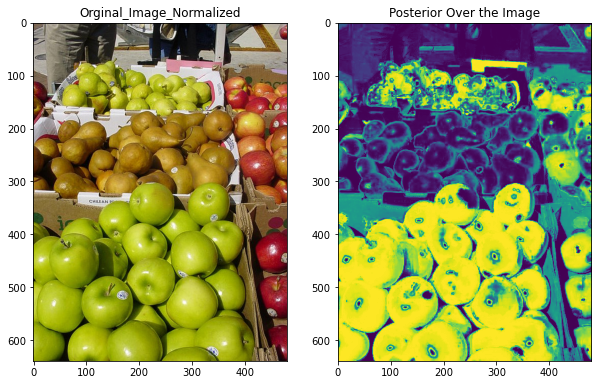

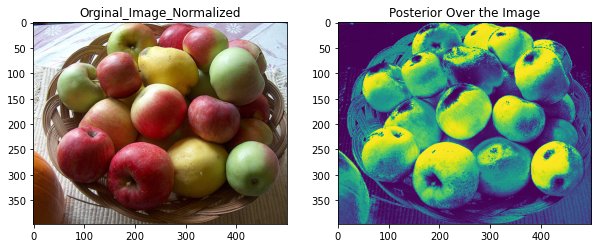

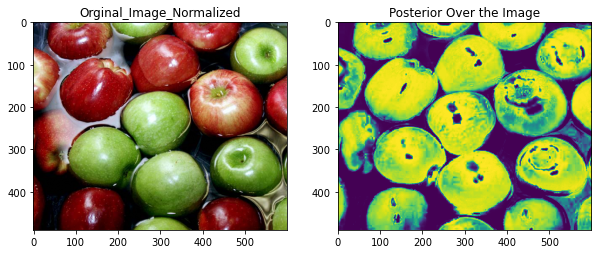

In [43]:
c=A.ROC(folder='Apples/Apples',ret=True,disp=False)

### These figures above are that of the test apples & their corresponding posterior as per our model. Qualitatively, we can see that shadows & colour play a massive role in whether our model can accurately predict an apple from a background. This is explored further below.


### 

## PART D Plotting Given Test data,ROC and their posteriors according to the trained model. 
### If the image happens to have a mask it also outputs the ROC curve and the F1 score. 


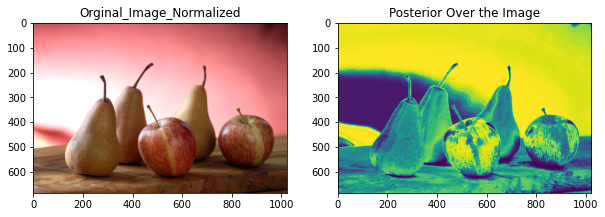

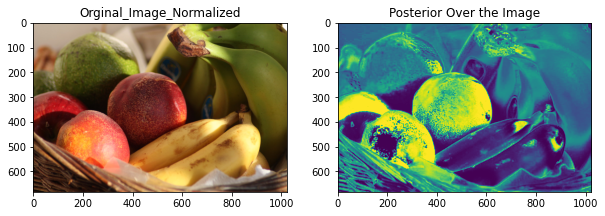

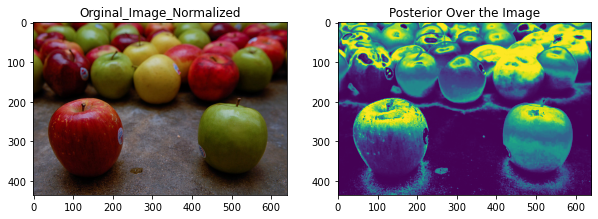

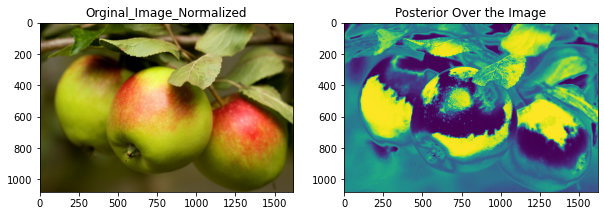

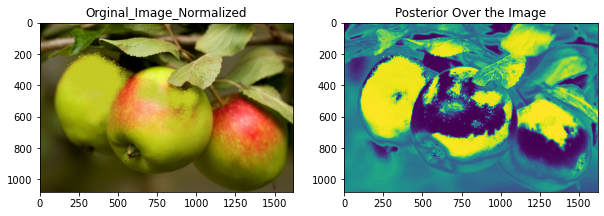

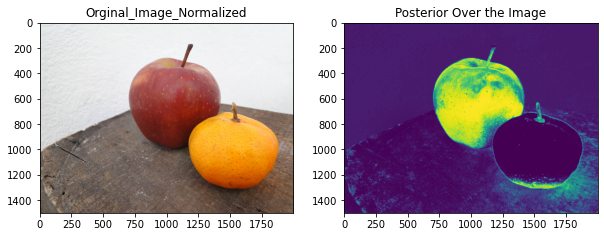

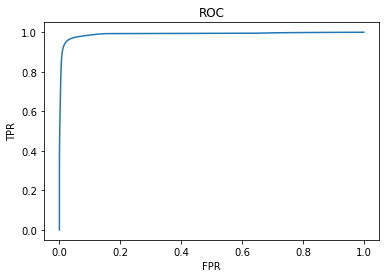

The best F1 score is for image Bbr98ad4z0A-ctgXo3gdwu8-original: is 0.92


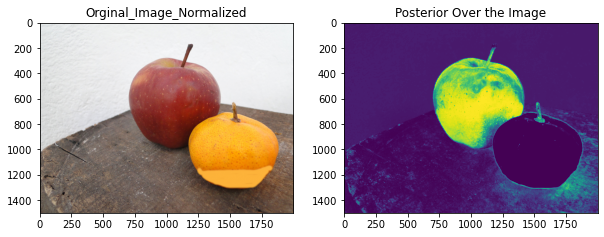

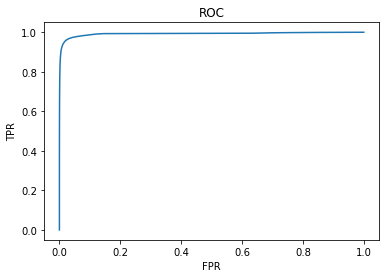

The best F1 score is for image modified_test_image: is 0.93


In [25]:
c=A.ROC(folder='testApples/testApples',ret=True,disp=True)

### For the given test image the model seems to perform really well. The ROC is in the upper left quadrant which means we are getting a good area under the curve ( AUC ) and high values of TPR and lower values of FPR.

* ### A pattern that seems to be emerging seems like the model focuses on a mix of red and green colours which follows because it was trained on apples which were red and green. 

*  ### For the image#5 (Apple & Orange) where the mask was given to us and some other images as well there seems to be a confusion when there is a shadow. The bottom part of the orange is assigned a higher probability that it should.
*  ### The colour confusion is the most visible in the image #1(Apples & pears with a background of red).  It assigns a higher probability to the background.

### To prove that the shadow is disrupting the classification, ( as per the suggestion in the coursework ), I digitally maniputaled image #4 and image#5 and removed the shadows on one of the apples, and removed the shadow at the bottom of the orange. This resulted in a better posterior over the image. For the test image we can clearly see the misclassified bottom of the orange is now classified as "not apple, or background".



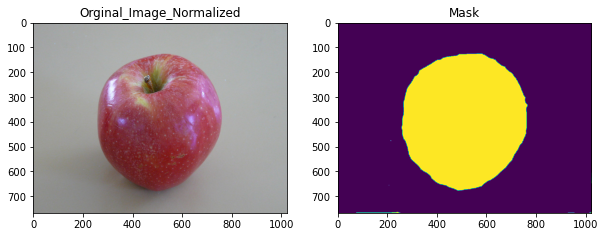

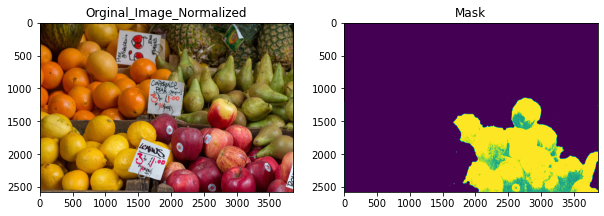

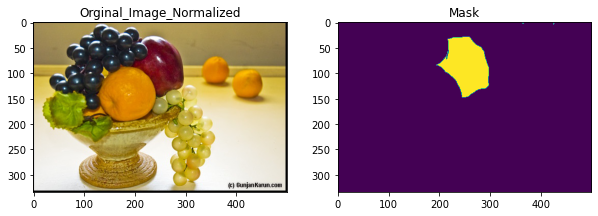

In [17]:
B=classifier()
B.process_images("newimage/*.png","newimage/*.jpg",disp=True,ret=False)


### The new images and their corresponding masks have been displayed in the plot above


### PART E Plotting Posteriors and masks for new test_images that I downloaded and drew the mask for

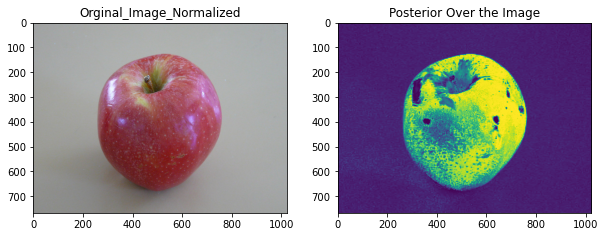

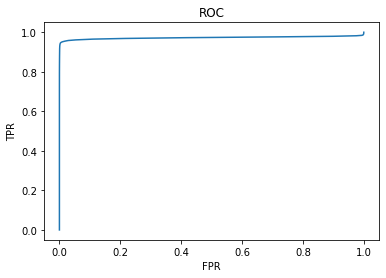

The best F1 score is for image 517372853_e959db10ca_b: is 0.97


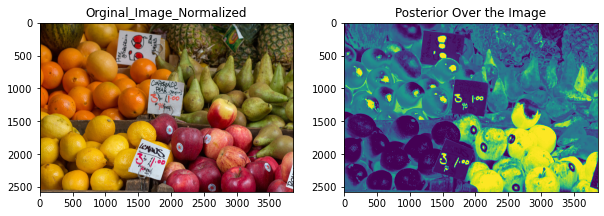

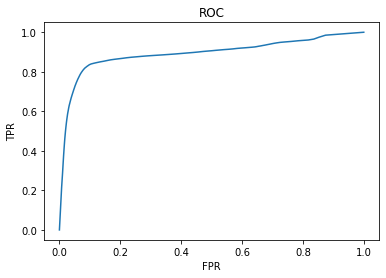

The best F1 score is for image borough-market-fresh-fruit-iStock-958388254: is 0.75


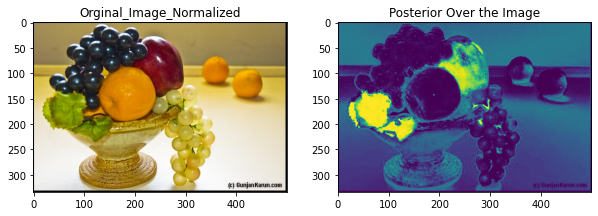

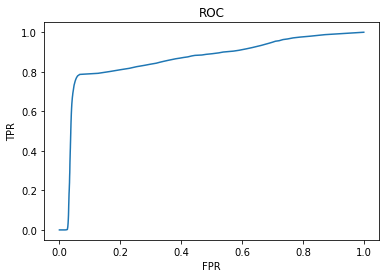

The best F1 score is for image myimage: is 0.53


In [28]:
c=A.ROC(folder='newimage')



* ### The classifier has no problems when the apple is consistently red and the background are a different colour. We can see a high AUC ROC & a high F1 score for image #1 [ only red apple with background ].

* ### If we look at the image #2 [ a variety of fruits with a sign ] it assigns a high probability even to the number which is in red.

* ### I chose this specific image #3 [ apples,oranges,grapes,cactus ] to show that *the model wrongly thinks the cactus is an apple because of it's colour*. It also highlights the top part of the apple which is misclassified due to the white reflection. 

* ### For the model to not misrecognize red backgrounds we would need a model that *can recognize texture* ( so it can tell a wall from an apple). Passing our images through multiple gabour filters [ as suggested in the assignment ] could be a way to combat this.



### PART F
### We might overfit if we only use metrics from the training set. We need to validate our model with a separate validation set for our model to be well generalized when we test it on our testing set. At the end of the day, we want our model to do well on data that it hasn't seen. For example, if we had to choose an optimal "K" (number of Gaussians), if we iterate through K, and choose the one with best F1 score for the training data, that has no guarantee that it would do well on an unknown image. Thus, we split our existing dataset into a train, test & a validation set (80%,10%,10% is a common choice). As we are training the model with each K, we check our validation set metric and choose the one with the highest F1 score or AUC ROC (This process is known as hyper-parameter tuning, with K being our hyper-parameter in this case). 

